### Importing and Loading the Dataset

In [77]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from pyspark.sql.functions import when
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline 

In [78]:
spark=SparkSession.builder.appName('Bank_Churn_Dataset').getOrCreate()

In [79]:
# Read the csv file into pyspark
df_pyspark = spark.read.option('header','true').csv('Churn_Modelling.csv', inferSchema=True) 

### Exploring the Data

In [80]:
df_pyspark.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|     Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|     Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93

In [81]:
# Drop Irrelevant Columnns: Rownumber, CustomerId, Surname
df_pyspark = df_pyspark.drop('RowNumber','CustomerId','Surname')

In [82]:
# Check the schema datatypes: All columns have their proper datatypes
df_pyspark.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [83]:
# Summary of the dataframe
df_pyspark.describe().show()

+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|         650.5288|     NULL|  NULL|           38.9218|            5.0128|76485.88928799961|            1.5302|             0.7055|             0.5151|100090.2398809998|             0.2037|
| stddev|9

In [84]:
# Dataset doesn't have Null values since the count remains the same
df_pyspark.na.drop(how='any').describe().show()

+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|         650.5288|     NULL|  NULL|           38.9218|            5.0128|76485.88928799961|            1.5302|             0.7055|             0.5151|100090.2398809998|             0.2037|
| stddev|9

In [85]:
# check all unique values of tenure
[i for i in df_pyspark.select('Tenure').distinct().collect()] 

[Row(Tenure=1),
 Row(Tenure=6),
 Row(Tenure=3),
 Row(Tenure=5),
 Row(Tenure=9),
 Row(Tenure=4),
 Row(Tenure=8),
 Row(Tenure=7),
 Row(Tenure=10),
 Row(Tenure=2),
 Row(Tenure=0)]

In [86]:
# check all unique values of geography
[i for i in df_pyspark.select('Geography').distinct().collect()] 

[Row(Geography='Germany'), Row(Geography='France'), Row(Geography='Spain')]

In [87]:
df_pyspark.createOrReplaceTempView("churn_table")
# 20 percent of the customers have left
query = """
    SELECT
        Exited,
        COUNT(*) AS customer_count,
        COUNT(*) * 100.0 / SUM(COUNT(*)) OVER() AS churn_rate
    FROM
        churn_table
    GROUP BY Exited;
        """
spark.sql(query).show()

+------+--------------+-----------------+
|Exited|customer_count|       churn_rate|
+------+--------------+-----------------+
|     1|          2037|20.37000000000000|
|     0|          7963|79.63000000000000|
+------+--------------+-----------------+



In [88]:
# Majority of customers are within 500-800 credit score range
# Additionally, majority of the leavers are within the 600-700 credit score range, but the higest churn rate is seen in 400 credit score level
query = """
    SELECT
        ROUND(CreditScore, -2) AS credit_score_bucket,
         Exited,
        COUNT(*) AS frequency,
        ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER(PARTITION BY ROUND(CreditScore, -2) ),2) AS churn_percentage
    FROM
        churn_table
    GROUP BY Exited, ROUND(CreditScore, -2)
    ORDER BY credit_score_bucket, Exited;
        """
spark.sql(query).show()

+-------------------+------+---------+----------------+
|credit_score_bucket|Exited|frequency|churn_percentage|
+-------------------+------+---------+----------------+
|                400|     0|      124|           67.03|
|                400|     1|       61|           32.97|
|                500|     0|     1105|           78.65|
|                500|     1|      300|           21.35|
|                600|     0|     2622|           79.21|
|                600|     1|      688|           20.79|
|                700|     0|     2810|           80.82|
|                700|     1|      667|           19.18|
|                800|     0|     1112|           80.00|
|                800|     1|      278|           20.00|
|                900|     0|      190|           81.55|
|                900|     1|       43|           18.45|
+-------------------+------+---------+----------------+



In [89]:
# More female exiters than male
query = """
    SELECT
        Gender,
        Exited,
        COUNT(*) AS frequency,
        ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER(PARTITION BY Gender),2) AS churn_percentage
    FROM
        churn_table
    GROUP BY Gender, Exited
    ORDER BY Gender,Exited;
        """
spark.sql(query).show()

+------+------+---------+----------------+
|Gender|Exited|frequency|churn_percentage|
+------+------+---------+----------------+
|Female|     0|     3404|           74.93|
|Female|     1|     1139|           25.07|
|  Male|     0|     4559|           83.54|
|  Male|     1|      898|           16.46|
+------+------+---------+----------------+



In [90]:
# Churn rate stays roughly the same throughout the tenure
query = """
   SELECT
        Tenure,
        Exited,
        COUNT(*) AS customer_count,
        ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER(PARTITION BY Tenure),2) AS churn_percentage
    FROM
        churn_table
    GROUP BY Tenure, Exited
    ORDER BY Tenure, Exited;
        """
spark.sql(query).show(25)

+------+------+--------------+----------------+
|Tenure|Exited|customer_count|churn_percentage|
+------+------+--------------+----------------+
|     0|     0|           318|           77.00|
|     0|     1|            95|           23.00|
|     1|     0|           803|           77.58|
|     1|     1|           232|           22.42|
|     2|     0|           847|           80.82|
|     2|     1|           201|           19.18|
|     3|     0|           796|           78.89|
|     3|     1|           213|           21.11|
|     4|     0|           786|           79.47|
|     4|     1|           203|           20.53|
|     5|     0|           803|           79.35|
|     5|     1|           209|           20.65|
|     6|     0|           771|           79.73|
|     6|     1|           196|           20.27|
|     7|     0|           851|           82.78|
|     7|     1|           177|           17.22|
|     8|     0|           828|           80.78|
|     8|     1|           197|          

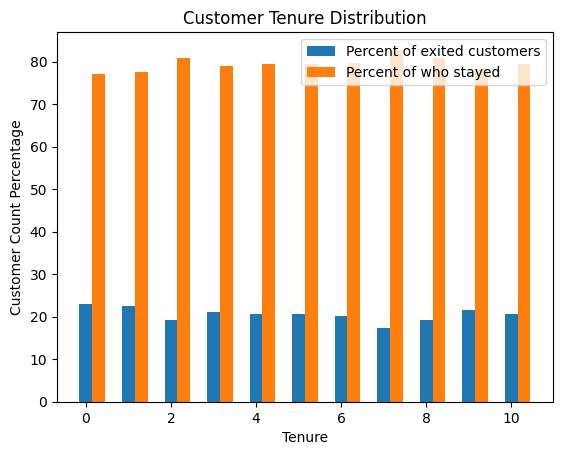

In [91]:
df_True_Exited = spark.sql(query).filter((spark.sql(query)['Exited'] == 1)) # Select all customers that exited
df_False_Exited = spark.sql(query).filter((spark.sql(query)['Exited'] == 0)) # Select all customers that didn't exit
pandas_True_Exited = df_True_Exited.toPandas()
pandas_False_Exited = df_False_Exited.toPandas()
width = 0.3
plt.bar(pandas_True_Exited["Tenure"], pandas_True_Exited["churn_percentage"], width, label="Percent of exited customers")
plt.bar(pandas_True_Exited["Tenure"] + width, pandas_False_Exited["churn_percentage"],width, label="Percent of who stayed")
plt.xlabel("Tenure")
plt.ylabel("Customer Count Percentage")
plt.title("Customer Tenure Distribution")
plt.legend()

In [92]:
query = """
    SELECT
        NumOfProducts AS products_bought,
         Exited,
        COUNT(*) AS frequency,
        ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER(PARTITION BY NumOfProducts ),2) AS churn_percentage
    FROM
        churn_table
    GROUP BY Exited, NumOfProducts
    ORDER BY NumOfProducts, Exited;
        """
spark.sql(query).show()

+---------------+------+---------+----------------+
|products_bought|Exited|frequency|churn_percentage|
+---------------+------+---------+----------------+
|              1|     0|     3675|           72.29|
|              1|     1|     1409|           27.71|
|              2|     0|     4242|           92.42|
|              2|     1|      348|            7.58|
|              3|     0|       46|           17.29|
|              3|     1|      220|           82.71|
|              4|     1|       60|          100.00|
+---------------+------+---------+----------------+



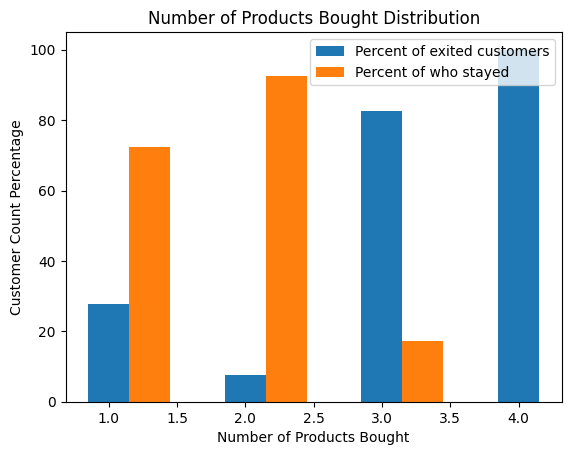

In [93]:
df_True_Exited = spark.sql(query).filter((spark.sql(query)['Exited'] == 1)) # Select all customers that exited
df_False_Exited = spark.sql(query).filter((spark.sql(query)['Exited'] == 0)) # Select all customers that didn't exit
pandas_True_Exited = df_True_Exited.toPandas()
pandas_False_Exited = df_False_Exited.toPandas()
width = 0.3
plt.bar(pandas_True_Exited["products_bought"], pandas_True_Exited["churn_percentage"], width, label="Percent of exited customers")
plt.bar(pandas_False_Exited["products_bought"] + width, pandas_False_Exited["churn_percentage"],width, label="Percent of who stayed")
plt.xlabel("Number of Products Bought")
plt.ylabel("Customer Count Percentage")
plt.title("Number of Products Bought Distribution")
plt.legend()

In [94]:
# Label encoding the Gender column: Male = 0, Female = 1
df_pyspark = df_pyspark.withColumn("Gender", when(df_pyspark.Gender == "Male", 0).otherwise(1)) 

In [95]:
# One hot encode the geography categories (France, Spain, Germany)
pandas_df = df_pyspark.toPandas() # conver the pyspark dataframe to pandas dataframe for one hot encoding
ohe=OneHotEncoder(sparse_output=False).set_output(transform='pandas')
ohe_encoded = ohe.fit_transform(pandas_df['Geography'].values.reshape(-1, 1))
pandas_df = pd.concat([pandas_df, ohe_encoded], axis=1).drop(columns=['Geography'])

In [96]:
# rename the geography columns
pandas_df = pandas_df.rename(columns={"x0_France":"France","x0_Germany":"Germany", "x0_Spain":"Spain" })

In [97]:
# Split the dataset before scaling to prevent data leakage
X = pandas_df.drop('Exited', axis='columns')
y = pandas_df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)

In [99]:
# Standarize both / convet to Z scores for numerical columns (robust to outliers)
binary_columns = [col for col in pandas_df.columns if pandas_df[col].nunique() == 2] # binary datatype columns 
non_binary_columns = [col for col in pandas_df.columns if col not in binary_columns] # Non Binary datatype columns

scaler = StandardScaler() # Standarize the training part of the dataset after splitting
X_train[non_binary_columns] = scaler.fit_transform(X_train[non_binary_columns])
X_test[non_binary_columns] = scaler.fit_transform(X_test[non_binary_columns])

In [100]:
# Recombine the train and test dataset  and export them as csv respectively
Train_data=pd.concat([X_train, y_train], axis=1)
Test_data=pd.concat([X_test, y_test], axis=1)

Train_data.to_csv('Train_Bank_Churn_Dataset.csv', index=False)
Test_data.to_csv('Test_Bank_Churn_Dataset.csv', index=False)
